The **PolyFactory** library looks at _models.py_ types (e.g. email: str) and automatically knows to generate strings like user@example.com instead of random text 

### Imports & Setup

In [1]:
import sys
import os
import random
import pandas as pd
from datetime import datetime, timedelta

In [4]:
# hack to allow importing from 'app' folder one level up
sys.path.append(os.path.abspath(".."))

In [6]:
from sqlmodel import SQLModel, Session, select
from polyfactory.factories.pydantic_factory import ModelFactory

In [7]:
# Import our model definitions
from app.models import Customer, Product, Order, OrderStatus, RefundTicket
from app.utils.db import engine


In [8]:
# Reset the database to clean slate
SQLModel.metadata.drop_all(engine)
SQLModel.metadata.create_all(engine)
print("Database reset and tables created")

Database reset and tables created


### Define Factories (The Data Generator)

In [10]:
# We define "How" to generate data
# PolyFactory handles the boring stuff (strings, ints), we handle specific business logis

class CustomerFactory(ModelFactory[Customer]):
    __model__ = Customer

class ProductFactory(ModelFactory[Product]):
    __model__ = Product

    # we override these fields to make them look more realistic
    price = lambda: round(random.uniform(10.0, 500.0), 2)
    stock_level = lambda: random.randint(0, 100)
    category = lambda: random.choice(["Electronics", "Home & Kitchen", "Fashion", "Sports"])

print("Factories defined")

Factories defined


### Generate and Insert Data

In [11]:
with Session(engine) as session:
    # 1. Create Customers 
    print("generating customers...")
    customers = CustomerFactory.batch(50)
    session.add_all(customers)
    session.commit() # Save so they get IDs
    print(f"created {len(customers)} customers")

    # 2. Create Products
    print("generating products...")
    products = ProductFactory.batch(20)
    session.add_all(products)
    session.commit() # Save so they get IDs
    print(f"created {len(products)} products")

    # 3. Create Orders
    # We can't use a Factory easily here becase Orders need valid Customer and Product IDs
    # We write a simple loop instead
    print("generating orders...")
    orders = []
    for _ in range(150):
        # Pick a random real customer and product
        customer = random.choice(customers)
        product = random.choice(products)
        qty = random.randint(1, 3)
        
        # Logic: 10% chance the order is already returned
        status = random.choice(list(OrderStatus))

        order = Order(
            customer_id=customer.id,
            product_id=product.id,
            quantity=qty,
            total_price=product.price * qty,
            status=status,
            order_date=datetime.utcnow() - timedelta(days=random.randint(1, 90))
        )
        orders.append(order)

    session.add_all(orders)
    session.commit()
    print(f"created {len(orders)} orders")

generating customers...
created 50 customers
generating products...
created 20 products
generating orders...
created 150 orders


/var/folders/dg/ngcksq_96_16g504zwmnhkcc0000gn/T/ipykernel_20569/1128567695.py:36: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  order_date=datetime.utcnow() - timedelta(days=random.randint(1, 90))


### Verify and Sanity Check the Data

In [12]:
with Session(engine) as session:
    statement = select(Order)
    results = session.exec(statement).all()

    # Convert list of dicts to Pandas
    data = [o.model_dump() for o in results]
    df = pd.DataFrame(data)

# Display first 5 rows
df.head()

,id,quantity,status,customer_id,product_id,total_price,order_date
0,1,3,OrderStatus.PROCESSING,4307,4617,455.55,2025-12-17 22:25:23.862820
1,2,3,OrderStatus.DELIVERED,957,4136,961.32,2025-11-28 22:25:23.863760
2,3,2,OrderStatus.SHIPPED,7447,8281,686.28,2025-10-07 22:25:23.864120
3,4,2,OrderStatus.RETURNED,9816,4136,640.88,2025-09-30 22:25:23.864262
4,5,1,OrderStatus.SHIPPED,9828,5912,98.54,2025-11-04 22:25:23.864486


### Setup Visualization

In [13]:
import matplotlib.pyplot as plt

# Increase display width so that tables don't cut off
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)


In [ ]:
# Load and join data

with Session(engine) as session:
    # 1. Fetch All data
    customers_data = session.exec(select(Customer)).all()
    orders_data = session.exec(select(Order)).all()
    products_data = session.exec(select(Product)).all()
    
    # 2. Convert to Dataframes
    df_customers = pd.DataFrame([c.model_dump() for c in customers_data])
    df_orders = pd.DataFrame([o.model_dump() for o in orders_data])
    df_products = pd.DataFrame([p.model_dump() for p in products_data])

    # 3. Rename ID columns to avoid confusion before merging
    df_customers = df_customers.rename(columns={"id": "customer_id", "name": "customer_name"})
    df_products = df_products.rename(columns={"id": "product_id", "name": "product_name", "category": "product_category"})

    # 4. Merge (Join) tables: Order -> Product -> Customer
    # This creates one "Masster Table" of every transaction
    full_df = df_orders.merge(df_customers, on="customer_id", how="left")
    full_df = full_df.merge(df_products, on="product_id", how="left")
    

# Show first 5 transactions with human-readable names
print("Master Transaction Table (First 5 Rows)")
full_df.head()

Master Transaction Table (First 5 Rows)


,id,quantity,status,customer_id,product_id,total_price,order_date,email,customer_name,is_vip,stock_level,product_name,description,price,product_category
0,1,3,OrderStatus.PROCESSING,4307,4617,455.55,2025-12-17 22:25:23.862820,QFECTZfMmcjZqgrqQEiy,IgTwEHRNdtNEvQOFbXaI,False,2,vtTuQigkySfgdhcJLrqY,iFrOEPKVooJtENSkoVYQ,151.85,Electronics
1,2,3,OrderStatus.DELIVERED,957,4136,961.32,2025-11-28 22:25:23.863760,VzgVvzWrslEccmSumpui,YyWGJRSSzGLSHuXwayLV,True,12,sxHbLEVcObGvJCnGkFbx,lGSdyZjDLwuwDyhvgoPc,320.44,Sports
2,3,2,OrderStatus.SHIPPED,7447,8281,686.28,2025-10-07 22:25:23.864120,jYAIseLeTkDKLBAfkucM,mXDPisKsjzhirOARKujY,False,71,egqetWIDncNItAOQiLdi,QEqryQAIybmgCeKQJtZs,343.14,Sports
3,4,2,OrderStatus.RETURNED,9816,4136,640.88,2025-09-30 22:25:23.864262,DMWZOkkoUyFZQWZiJGKb,txGrSfUCcklbnOXGAsya,False,12,sxHbLEVcObGvJCnGkFbx,lGSdyZjDLwuwDyhvgoPc,320.44,Sports
4,5,1,OrderStatus.SHIPPED,9828,5912,98.54,2025-11-04 22:25:23.864486,JvALAVcHQaAaCkDtBtwJ,rPWDsRxEoiSbOYJjFNZk,False,34,FigRGAaYGywOIQzBBekj,HpbPqEhbUgcLkcwOyhFY,98.54,Home & Kitchen


### Business Logic Validation

In [15]:
print("--- 🔍 Integrity Checks ---")

# 1. Check Status Distribution (Did our weights work?)
status_counts = full_df['status'].value_counts(normalize=True) * 100
print("\n1. Order Status Distribution (Target: ~10% Returned):")
print(status_counts.round(1).astype(str) + '%')

# 2. Check VIP Logic (Who are our top spenders?)
top_spenders = full_df.groupby('customer_name')['total_price'].sum().sort_values(ascending=False).head(3)
print("\n2. Top 3 Big Spenders:")
print(top_spenders)

# 3. Revenue by Category
print("\n3. Revenue by Product Category:")
category_rev = full_df.groupby('product_category')['total_price'].sum().sort_values(ascending=False)
print(category_rev)

--- 🔍 Integrity Checks ---

1. Order Status Distribution (Target: ~10% Returned):
status
OrderStatus.RETURNED      26.7%
OrderStatus.SHIPPED       26.0%
OrderStatus.DELIVERED     25.3%
OrderStatus.PROCESSING    22.0%
Name: proportion, dtype: object

2. Top 3 Big Spenders:
customer_name
xazMlvDkMHjbqvZeLWNR    4561.01
pZqTWWLSPKJLOwZwaUiG    4460.51
xYpVXpnMIFCZGgVNoauO    3656.14
Name: total_price, dtype: float64

3. Revenue by Product Category:
product_category
Sports            47712.45
Fashion           12678.64
Electronics       12482.14
Home & Kitchen     2509.44
Name: total_price, dtype: float64


### Visualization

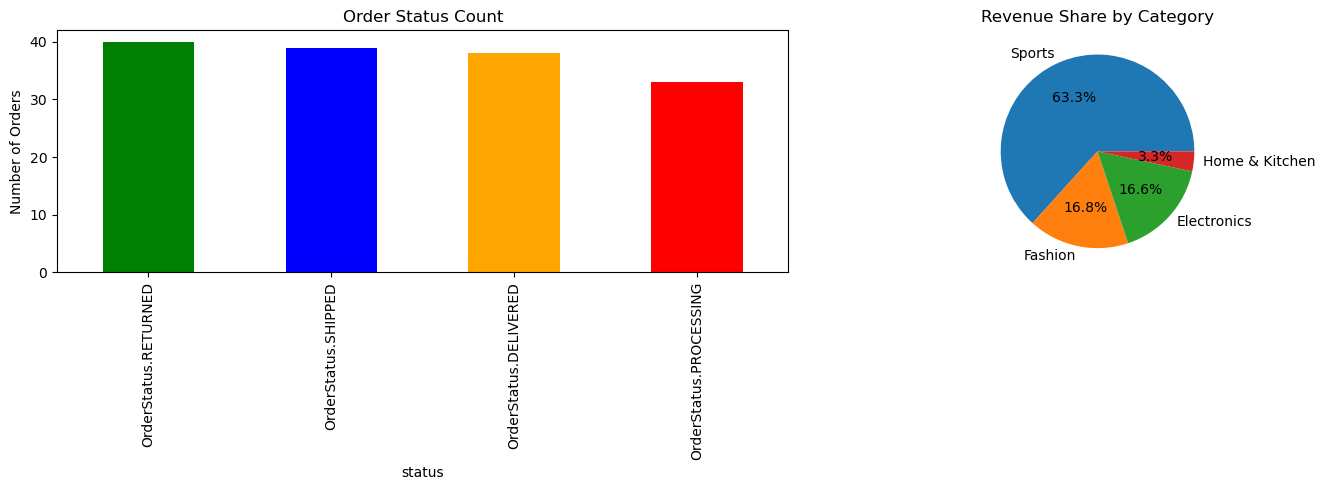

In [16]:
# Create a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Chart 1: Order Statuses
full_df['status'].value_counts().plot(kind='bar', color=['green', 'blue', 'orange', 'red'], ax=axes[0])
axes[0].set_title('Order Status Count')
axes[0].set_ylabel('Number of Orders')

# Chart 2: Revenue by Category
category_rev.plot(kind='pie', autopct='%1.1f%%', ax=axes[1])
axes[1].set_title('Revenue Share by Category')
axes[1].set_ylabel('') # Hide y-label for cleaner look

plt.tight_layout()
plt.show()